# Size Structure distribution

This notebook explores the possibility of parameterizing the size distribution of plankton by the number of plankton in a specific mass range and the total biomass. To do so, we need to import several python libraries.

In [1]:
import numpy as np
from numpy import vectorize

from scipy import optimize

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # Large figures

## Starting Point

A common assumption to make is that the relationship between the size of plankton and its abundance is log-linear. We state that explicitly by defining *r* to be the equivalent spherical diameter (ESD, units: m) and *n(r)* to be abundance (units: count per length, where length refers to bin length not phytoplankton ESD):

*n(r) = n<sub>0</sub>(r/r<sub>0</sub>)<sup>-beta</sup>*

Where *n<sub>0</sub>* is the abundance at a given size *r<sub>0</sub>* and *-beta* defines the slope in the log-linear relationship (the *-* is included because larger plankton are less abundant and it is useful for *beta>0*).

More on specifying *r<sub>0</sub>* later, but we will see that there is a natural choice given our application.

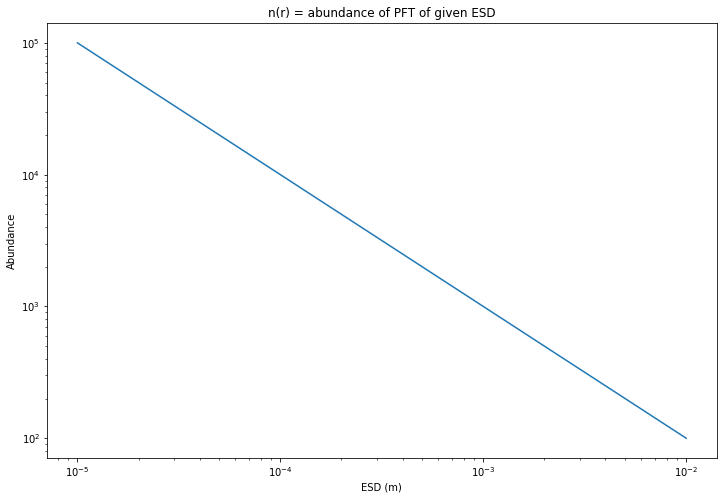

In [2]:
# r is Plankton ESD (in meters); 10 um -> 1 cm seems like a reasonable range
r = 10**(np.linspace(-5, -2, num=100))

def n(r):
    r0 = 1
    n0 = 1
    beta = 1
    return n0 * (r/r0)**-beta

plt.loglog(r, n(r));
plt.title('n(r) = abundance of PFT of given ESD'); plt.xlabel('ESD (m)'); plt.ylabel('Abundance');

# We will redefine n [permanently] later in the notebook
del n

We also know that there is a power law relating plankton ESD and plankton mass. Defining the mass to be *m*, we state that relationship as

*m(r) = C<sub>m</sub>(r/r<sub>0</sub>)<sup>alpha</sup>*

Where *C<sub>m</sub>* and *alpha* are parameters we need to get from the literature.

## Getting to the Parameterization

It should be pointed out that, for a size range *[r<sub>1</sub>,r<sub>2</sub>]* the total plankton count is

N = I*<sub>r<sub>1</sub></sub><sup>r<sub>2</sub></sup> n(r)dr*

and the total plankton mass is

M = I*<sub>r<sub>1</sub></sub><sup>r<sub>2</sub></sup> n(r)m(r)dr*

where I is the integral operator. So if we know *C<sub>m</sub>*, *alpha*, and *r<sub>0</sub>* then we can define plankton count and mass for a size range *[r<sub>1</sub>,r<sub>2</sub>]* as a function of *n<sub>0</sub>* and *beta*:

In [3]:
def power_int(x, t1, t2):
    if (x == -1):
        return np.log(t2) - np.log(t1)
    return (t2**(x+1.) - t1**(x+1.))/(x+1.)
vpower_int = vectorize(power_int)

def N(n0,beta):
    return n0*(r0**beta)*vpower_int(-beta,r1,r2)

def M(n0,beta):
    return n0*cm*(r0**(beta-alpha))*vpower_int(alpha-beta,r1,r2)

To see if this function is invertible, we look at contours of *N* and *M* for some realistic choices of the parameters *C<sub>m</sub>*, *alpha*, *r<sub>1</sub>*, *r<sub>2</sub>*, and *r<sub>0</sub>* and over reasonable ranges of *(n<sub>0</sub>, beta)*-space.

## Defining *r<sub>0</sub>*

coming soon? I think we want r0 = r2, though...

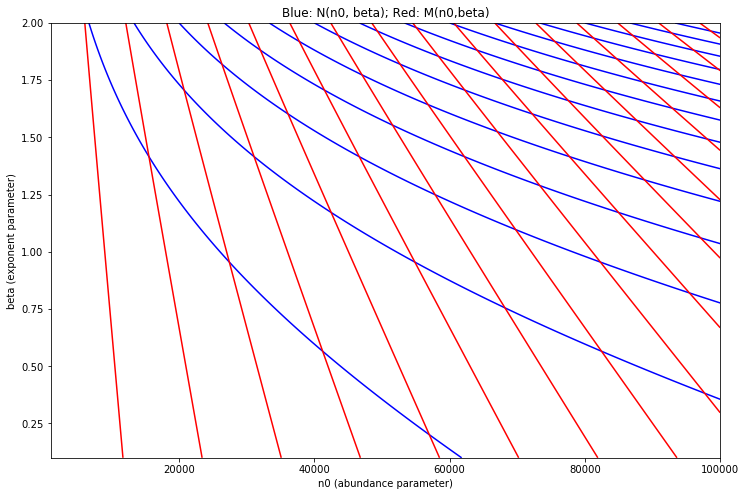

In [4]:
cm = 1
alpha = 3
r1 = 10**-4
r2 = 10**-3
# For now we take r0 to be r2
r0 = r2

# beta between 0.1 and 2
beta = np.linspace(0.1, 2, num=191)

# n0 between 1000 and 100000
n0 = 10**(np.linspace(3,5,num=201))

# grid for contours
X, Y = np.meshgrid(n0, beta)
plt.rcParams['contour.negative_linestyle'] = 'solid';
plt.contour(X, Y, N(X,Y), 16, colors='b');
plt.contour(X, Y, M(X,Y), 16, colors='r');
plt.title("Blue: N(n0, beta); Red: M(n0,beta)")
plt.xlabel("n0 (abundance parameter)"); plt.ylabel("beta (exponent parameter)");


It does appear as though the mapping from *(n<sub>0</sub>, beta)* to *(N, M)* is one to one... so the next step is to determine *n<sub>0</sub>(N,M)* and *beta(N,M)*. A good place to start is by noting that

*N(n<sub>0</sub>,beta) = n<sub>0</sub>F(beta)*
*M(n<sub>0</sub>,beta) = n<sub>0</sub>G(beta)*

So given *N(n<sub>0</sub>,beta) = N<sub>1</sub>* and *M(n<sub>0</sub>,beta) = M<sub>1</sub>* it follows that

*M<sub>1</sub> / N<sub>1</sub> = G(beta)/F(beta)* is a function purely of *beta*; if *G(beta)/F(beta)* is invertible that yields *beta(N,M)*

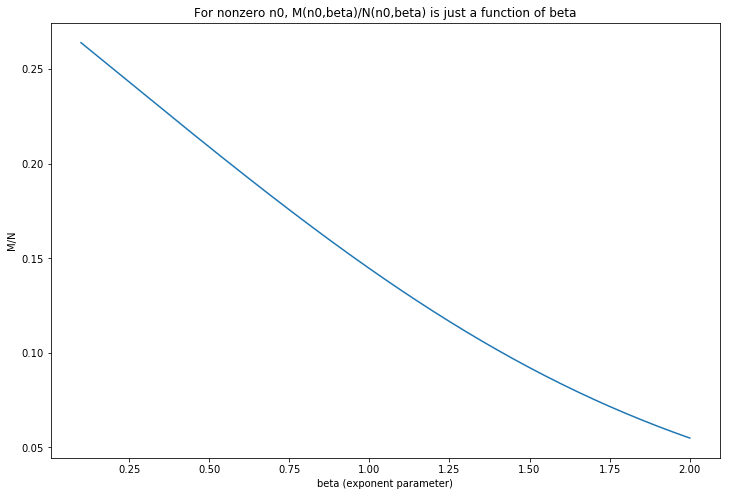

In [5]:
def F(beta):
    return N(1,beta)

def G(beta):
    return M(1,beta)

plt.plot(beta,G(beta)/F(beta));
plt.title("For nonzero n0, M(n0,beta)/N(n0,beta) is just a function of beta");
plt.xlabel("beta (exponent parameter)"); plt.ylabel("M/N");


In fact, *G(beta)/F(beta)* appears nearly linear, so Newton's should make quick work of finding *beta*.

Once we know *beta* then *n<sub>0</sub>* falls out from either

*N(n<sub>0</sub>,beta)=n<sub>0</sub>F(beta)* => *n<sub>0</sub>=N<sub>1</sub>/F(beta)*

or

*M(n<sub>0</sub>,beta)=n<sub>0</sub>G(beta)* => *n<sub>0</sub>=M<sub>1</sub>/G(beta)*

To test this out with concrete numbers, let's take *n<sub>0</sub>=10<sup>4</sup>* and *beta=1.05*

In [6]:
beta = 1.05
n0 = 10**3
N1 = N(n0,beta)
M1 = M(n0,beta)
del beta, n0

print N1,M1,M1/N1

2.44036908604 0.338602705609 0.13875061258


Given *N<sub>1</sub>* and *M<sub>1</sub>* above, can we find *beta* and *n<sub>0</sub>*?

In [7]:
def find_beta(beta):
    return G(beta)/F(beta) - M1/N1

def find_n0(n0):
    return 

beta = optimize.fsolve(find_beta,1)
n0 = N1/F(beta)
print beta, n0

[ 1.05] [ 1000.]


The above shows we can, the next step (I think) is to write a python script that does the root-finding instead of relying on optimize.fsolve (that is what we will need to translate to Fortran for MARBL); I think that will require defining *F(beta)*, *F'(beta)*, *G(beta)*, and *G'(beta)* explicitly; from the plot above, Newton's method seems like a reasonable way to solve for *beta*